# Deep Learning Assignment 4: CNNs for Face Identification

We will perform face identification using a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class calssification problem where we have training/testing images for a set of subjects (classes). In 2014, researchers were able to surpass human accuracy in facial identification tasks using CNN models (along with advanced deep learning techniques)!

We will observe the performance of a traditional face identification method, [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface). We will then build a CNN model in order to surpass the accuracy of the traditional Eigenfaces technique. In the process, we will learn about the great power of CNNs!

### Requirements

1. Python 3.6
2. `pip install numpy`
3. `pip install sklearn`
4. `pip install matplotlib`
5. `pip install tensorflow==2.0.0`


### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)


In [1]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

Let's start by downloading and setting up a subset of the aligned and segmented version of the LFW dataset. We will only get subjects with at least 20 corresponding images. We will also get the grayscale versions of the images. This may take a few minutes . . .

In [2]:
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

The downloaded `data_x` will be the flattened vector representation of the images.

We will reshape the vector respresentations back into the original grayscale images and store the images back in `data_x`.

In [3]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 62
Number of images: 3023

data_x shape: (3023, 62, 47, 1)
data_y shape: (3023,)


As we can see, the dataset is made up of `3023` images of `62` subjects (or classes).

Each image is a `62x47x1`-dimensional matrix containing 8-bit (0-255) grayscale pixel values.

Let's visualize a few of the grayscale images.

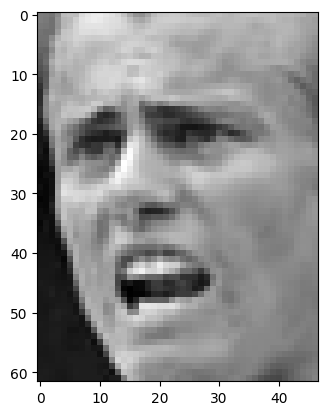

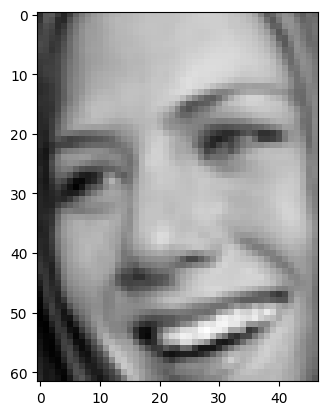

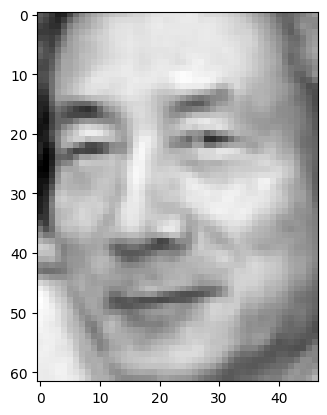

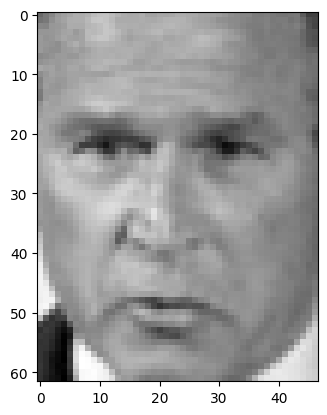

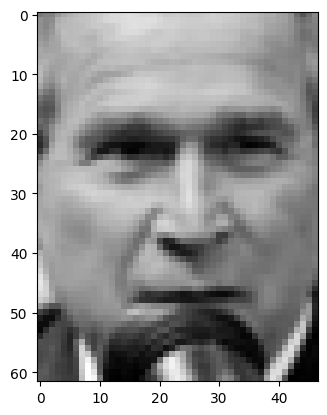

In [ ]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

Now, let's split the dataset into train and test sets so we can perform face identification!

We will perform a `90/10` stratified split. This means that `90%` of each subject's images are placed in the train set, while the remaining `10%` of each subject's images are placed into the test set.

In [4]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (2720, 62, 47, 1)
train_y shape: (2720,)

test_x shape: (303, 62, 47, 1)
test_y shape: (303,)


### Eigenfaces Overview

Eigenfaces is a face identification technique proposed in 1987. It was a very popular algorithm through the 1990's and is still used today as a baseline algorithm when gauging the performance of proposed face identification techniques. Eigenfaces is used to extract features from facial images. Such facial features are more useful in identification tasks than the corresponding oringinal images. The facial features can then be used for identification by being classified by a multi-class classifier, such a logistic regression model.

### Eigenfaces Details

Eigenfaces is a Principcal Componet Analysis (PCA)-based dimensionality-reduction technique. Eigenfaces deals with the flattened vector representations of the face images.

We give the vector representation of the training images as input to the algorithm. The output of the algoirthm is a set of Eigenfaces (vectors) which we can use to project vector representations of images into a lower-dimensional space which (hopefully) encode important facial features.

Since the lower-dimensional space captures important facial features, Eigenfaces is used as a feature extraction technique. Given a facial image, we can reshape the image into a vector. Using the Eigenfaces, we reduce the dimensionality of the original vector into a vector which is more useful in identifying its corresponging subject. Therefore, we will use the Eigenfaces to extract facial features. Then, we will use a simple logistic regression classifier to classify the resulting facial features.

Let's start by flattening the training facial images. Then we will continue by computing the Eigenfaces which capture `95%` of the variance of the original dataset.

In [5]:
# flatten images
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (2720, 2914)
Eigenfaces shape: (202, 2914)


As we see, if we flatten the training images to gather their vector representations, we recieve `2720` vectors of size `2914`. We also see that we have found `173` Eigenfaces vectors of size `2914`.

If we reshape the set of Eigenfaces to the shape of the original images, they reveal intesting ghost faces (i.e. "Eigenfaces").

Let's view the first `10` Eigenfaces.

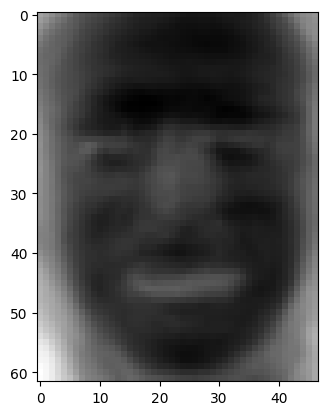

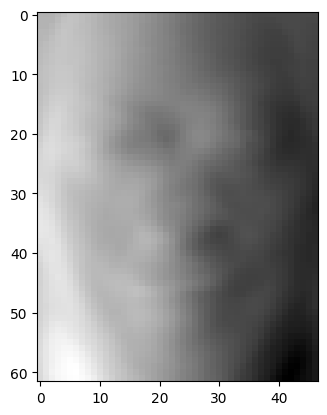

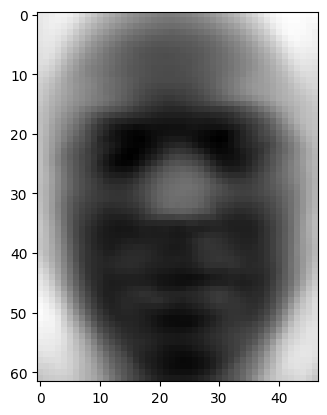

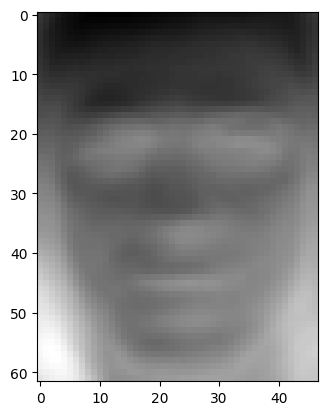

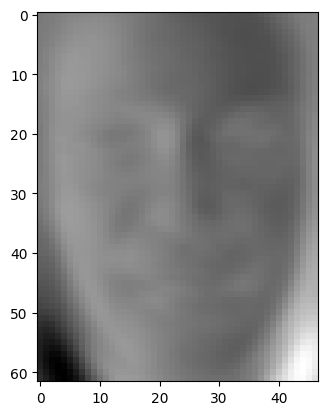

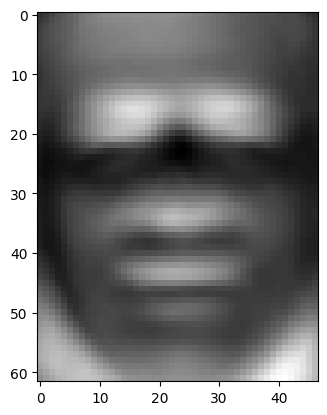

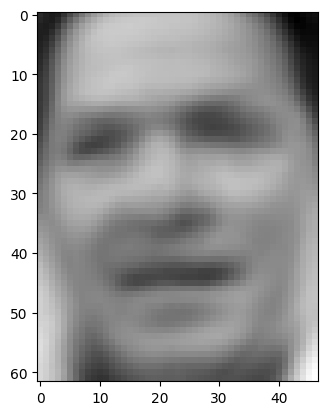

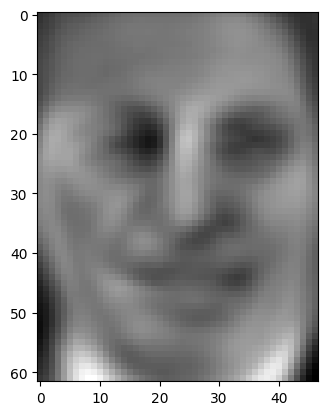

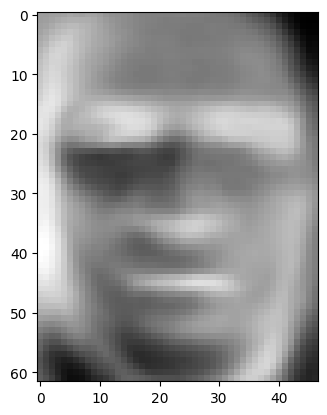

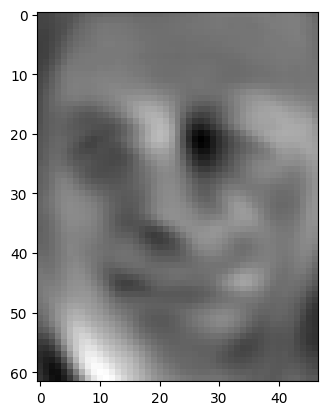

In [ ]:
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

Spooky!

Now, let's use the Eigenfaces to extract facial features from the training and test set vectors. Since we have `173` Eigenfaces, we will reduce the dimensionality of the `2914`-dimensional train/test vectors to `173`-dimensional train/test feature vectors.

In [6]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (2720, 2914)
Training features shape: (2720, 202)
Testing vectors shape: (303, 2914)
Testing features shape: (303, 202)


Great! Now that we have extracted facial features from the train and testing set, let's perform facial identification using a simple logistic regression model!

In [7]:
# specify the input size of the feature vectors
features = Input((train_features_x.shape[1],))
# a single fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(features)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
logistic_regression = Model(inputs=features, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(logistic_regression.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 202)]             0         
                                                                 
 dense (Dense)               (None, 62)                12586     
                                                                 
 activation (Activation)     (None, 62)                0         
                                                                 
Total params: 12586 (49.16 KB)
Trainable params: 12586 (49.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Your turn!

### Sample CNN Model
The Eigenfaces and logistic regression model doesn't perform that well on the unseen test set. Let's see how a simple CNN model compares.

Rather than dealing with vectors, we will begin working with the grayscale images directly.

Remember that a CNN learns convolution filters which extract the most useful features. Then, a small neural network at the end of the CNN architecture performs the multi-class classification. Therefore, the CNN will make things less complex for us as the CNN will learn to perform both feature extraction and classification!

<b> Complete the section below</b>

In [9]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam

# Specify the input size of the images
input_shape = (train_x.shape[1], train_x.shape[2], 1)
images = Input(shape=input_shape)

# A convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32, (9, 9), activation='relu', padding='valid')(images)

# A maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64, (11, 11), activation='relu', padding='valid')(x)

# A maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten extracted features to form a feature vector
x = Flatten()(x)

# A dropout layer for regularization (25% probability)
x = Dropout(0.25)(x)

# First fully-connected layer to map the features to vectors of size 256
x = Dense(256, activation='relu')(x)

# Another dropout layer for regularization (25% probability)
x = Dropout(0.25)(x)

# A single fully-connected layer to map the features to a logit vector with one logit per subject
# Use 'num_subjects' as the number of units in the output layer and 'softmax' activation
x = Dense(num_subjects, activation='softmax')(x)

# Create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=x)

# Compile the model so that it uses Adam for optimization during training with categorical cross-entropy loss
# Compile the model using 'sparse_categorical_crossentropy' as the loss function
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])


# Print out a summary of the model architecture
print(sample_cnn.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 39, 32)        2624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 19, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 9, 64)         247872    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0   

We have completed the sample CNN as specified by the comments but the above CNN Model doesn't excede the accuracy of Eigenvalues Model . The next code of the CNN model would excede the accuracies.

In [11]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on the training labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)

# Convert the class_weights array to a dictionary for use in the model.fit() function
class_weight_dict = dict(enumerate(class_weights))

# Now, you can use class_weight_dict when training the model
sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weight_dict,
               epochs=15, batch_size=64, verbose=1)


# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))

# train model, verbose set to 0 to supress output, wait a moment for training to complete
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y),
                        class_weight=class_weight_dict,
                        epochs=75, batch_size=128, verbose=0)


# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Epoch 1/15
43/43 [==============================] - 12s 13ms/step - loss: 4.1292 - acc: 0.0081 - val_loss: 4.1268 - val_acc: 0.0099
Epoch 2/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1279 - acc: 0.0063 - val_loss: 4.1271 - val_acc: 0.0198
Epoch 3/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1276 - acc: 0.0103 - val_loss: 4.1269 - val_acc: 0.0099
Epoch 4/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1275 - acc: 0.0092 - val_loss: 4.1284 - val_acc: 0.0066
Epoch 5/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1278 - acc: 0.0070 - val_loss: 4.1273 - val_acc: 0.0066
Epoch 6/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1275 - acc: 0.0081 - val_loss: 4.1276 - val_acc: 0.0099
Epoch 7/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1277 - acc: 0.0070 - val_loss: 4.1269 - val_acc: 0.0099
Epoch 8/15
43/43 [==============================] - 0s 6ms/step - loss: 4.1277 - acc: 0.

## More tasks

2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different
3. Build a fourth CNN model which achieves >70% test accuracy
4. Display a correctly identified image and a training image corresponding to the correct training subject
5. Display a incorrectly identified image and a training image corresponding to the correct training subject

##2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers.

CNN Model 1 (two convolutional layers, max-pooling layers, and two dense layers, designed for image classification tasks, using stochastic gradient descent (SGD) as the optimizer with a learning rate of 0.01 and 0.9 momentum, and it's trained for sparse categorical classification with 62 output classes.)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

input_shape = (train_x.shape[1], train_x.shape[2], 1)

inputs = Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(units=62, activation='softmax')(x)

model1 = Model(inputs=inputs, outputs=outputs)

model1.summary()

# Define SGD optimizer with learning rate and momentum
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

model1.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model1.fit(train_x, train_y, validation_data=(test_x, test_y),
              epochs=75, batch_size=64, verbose=0)

# Evaluate the model and get train/test accuracy
train_pred_model1 = np.argmax(model1.predict(train_x), axis=1)
test_pred_model1 = np.argmax(model1.predict(test_x), axis=1)

print("\nTraining accuracy using SGD-Optimized CNN model: {}".format(accuracy_score(train_y, train_pred_model1)))
print("Testing accuracy using SGD-Optimized CNN model: {}\n".format(accuracy_score(test_y, test_pred_model1)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 62, 47, 1)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 30, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 28, 20, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 14, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 8960)              0  

CNN Model 2 (consists of two convolutional layers followed by max-pooling layers, global average pooling, and two dense layers, designed for image classification with 124 output classes, using the Nadam optimizer with a learning rate of 0.001.)

In [22]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=124, activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model2.fit(train_x, train_y, validation_data=(test_x, test_y),
               #class_weight=class_weights,
               epochs=75, batch_size=64, verbose=0)

# evaluate model, get train/test accuracy
train_pred_model2 = np.argmax(model2.predict(train_x), axis=1)
test_pred_model2 = np.argmax(model2.predict(test_x), axis=1)
print("\nTraining accuracy using Nadam-Optimized CNN model: {}".format(accuracy_score(train_y, train_pred_model2)))
print("Testing accuracy using Nadam-Optimized CNN model: {}\n".format(accuracy_score(test_y, test_pred_model2)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

10/10 [==============================] - 0s 2ms/step

Training accuracy using Nadam-Optimized CNN model: 0.6113970588235295
Testing accuracy using Nadam-Optimized CNN model: 0.4752475247524752

Training accuracy using Eigenfaces and logistic regression model: 0.6264705882352941
Testing accuracy using Eigenfaces and logistic regression model: 0.41914191419141916


CNN Model 3 (a convolutional neural network (CNN) for image classification, featuring two convolutional layers with max-pooling, followed by dense layers, dropout for regularization, and a softmax output layer with 124 classes, using the RMSprop optimizer with a learning rate of 0.001.)

In [30]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units=124, activation='softmax')(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Use RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(train_x, train_y, validation_data=(test_x, test_y),
           epochs=75, batch_size=64, verbose=0)

# evaluate model, get train/test accuracy
train_pred_model3 = np.argmax(model3.predict(train_x), axis=1)
test_pred_model3 = np.argmax(model3.predict(test_x), axis=1)
print("\nTraining accuracy using RMS-Optimized CNN model: {}".format(accuracy_score(train_y, train_pred_model3)))
print("Testing accuracy using RMS-Optimized CNN model: {}\n".format(accuracy_score(test_y, test_pred_model3)))

print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))


10/10 [==============================] - 0s 2ms/step

Training accuracy using RMS-Optimized CNN model: 0.6988970588235294
Testing accuracy using RMS-Optimized CNN model: 0.5214521452145214

Training accuracy using Eigenfaces and logistic regression model: 0.6264705882352941
Testing accuracy using Eigenfaces and logistic regression model: 0.41914191419141916


### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)

Feel free to use the code above to get started on your own models!

Fourth CNN Model (a convolutional neural network (CNN) with two convolutional layers, max-pooling layers, and two dense layers, designed for image classification tasks, using the Adam optimizer, and it's trained for sparse categorical classification with 62 output classes.)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

input_shape = (train_x.shape[1], train_x.shape[2], 1,)

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=160, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=62, activation='softmax')(x)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model4.summary()

optimizer = keras.optimizers.Adam()
model4.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(train_x, train_y, validation_data=(test_x, test_y),
               epochs=75, batch_size=64, verbose=0)

# evaluate model, get train/test accuracy
train_pred_model4 = np.argmax(model4.predict(train_x), axis=1)
test_pred_model4= np.argmax(model4.predict(test_x), axis=1)
print("\nTraining accuracy using CNN4 model: {}".format(accuracy_score(train_y, train_pred_model4)))
print("Testing accuracy using CNN4 model: {}\n".format(accuracy_score(test_y, test_pred_model4)))

print("The sample CNN model beat the Eigenfaces and logistic regression model! :)")
print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 62, 47, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 60, 45, 30)        300       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 30, 22, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 28, 20, 30)        8130      
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 14, 10, 30)        0         
 ng2D)                                                           
                                                                 
 flatten_23 (Flatten)        (None, 4200)              0  

We see that the above CNN Model achieves an accuracy > 70%.

4. Display a correctly identified image and a training image corresponding to the correct training subject

10/10 [==============================] - 0s 2ms/step


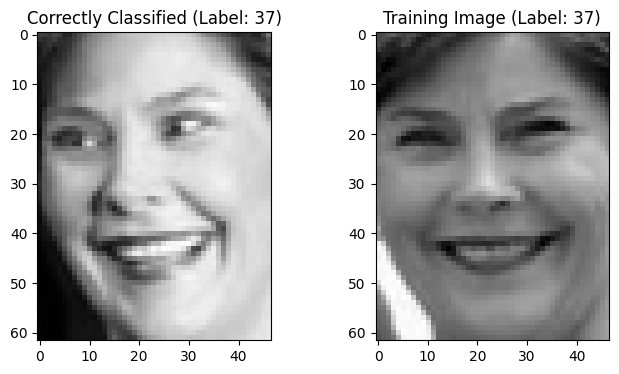

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'test_x' and 'test_y' contain your test dataset and labels
# You can use 'train_x' and 'train_y' for the training dataset and labels

# Get predictions on the test dataset
test_predictions = model4.predict(test_x)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Find the index of a correctly classified image
correctly_classified_index = np.where(test_pred_labels == test_y)[0][0]

# Display the correctly classified image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[correctly_classified_index][:, :, 0], cmap='gray')
plt.title(f'Correctly Classified (Label: {test_y[correctly_classified_index]})')

# Find the training image corresponding to the correct training subject
correct_subject_label = test_y[correctly_classified_index]
correct_subject_train_index = np.where(train_y == correct_subject_label)[0][0]

# Display the training image for the correct training subject
plt.subplot(1, 2, 2)
plt.imshow(train_x[correct_subject_train_index][:, :, 0], cmap='gray')
plt.title(f'Training Image (Label: {train_y[correct_subject_train_index]})')

plt.show()


5. Display a incorrectly identified image and a training image corresponding to the correct training subject.

10/10 [==============================] - 0s 2ms/step


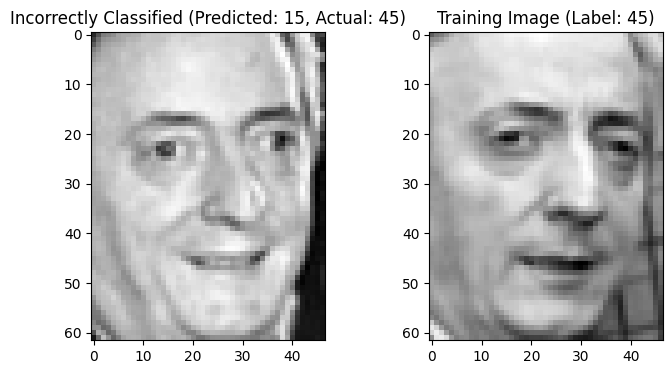

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'test_x' and 'test_y' contain your test dataset and labels
# You can use 'train_x' and 'train_y' for the training dataset and labels

# Get predictions on the test dataset
test_predictions = model4.predict(test_x)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Find the index of an incorrectly classified image
incorrectly_classified_indices = np.where(test_pred_labels != test_y)[0]

# Randomly select an index from the incorrectly classified images
incorrectly_classified_index = np.random.choice(incorrectly_classified_indices)

# Get the label that the model predicted
predicted_label = test_pred_labels[incorrectly_classified_index]

# Find the training image corresponding to the correct training subject
correct_subject_label = test_y[incorrectly_classified_index]
correct_subject_train_indices = np.where(train_y == correct_subject_label)[0]

# Randomly select an index from the correct subject's training images
correct_subject_train_index = np.random.choice(correct_subject_train_indices)

# Display the incorrectly classified image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[incorrectly_classified_index][:, :, 0], cmap='gray')
plt.title(f'Incorrectly Classified (Predicted: {predicted_label}, Actual: {test_y[incorrectly_classified_index]})')

# Display the training image for the correct training subject
plt.subplot(1, 2, 2)
plt.imshow(train_x[correct_subject_train_index][:, :, 0], cmap='gray')
plt.title(f'Training Image (Label: {train_y[correct_subject_train_index]})')

plt.show()
